In [31]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tabpfn_extensions import TabPFNRegressor,interpretability

# Import tabpfn adapters from interpretability module
from tabpfn_extensions.interpretability import shapiq as tabpfn_shapiq

In [32]:
import os
os.environ["OMP_NUM_THREADS"] = "5"  # 设置线程数为5，避免内存泄漏


In [33]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [34]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [35]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/中国10债Non-Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet
sheet.columns

Index(['中国10年期国债收益率Non-Trend/F0.2', 'M2同比', 'M1同比', '新增人民币贷款/中长期同差',
       '中国核心CPI当月同比', '70大中城市二手房价环比Non-Trend/F0.1', 'DR007利率/15DMA同差',
       '螺纹期货价格60日环比', '南华工业品指数60日环比', 'CNH HIBOR/3M',
       '10年期美国国债收益率Non-Trend/F0.2', '十年期国债动量', '一线二手房挂牌价指数4周环差'],
      dtype='object')

In [36]:

# 有月度数据 所以 数据 处理逻辑 就是 全部填充 然后再变成 工作日数据
#############  处理缺失值 ##############
fill_methods = {
    'M2同比':'interpolate', 
    'M1同比':'interpolate', 
    '新增人民币贷款/中长期同差':'interpolate',
    '中国核心CPI当月同比':'interpolate', 
    '70大中城市二手房价环比Non-Trend/F0.1':'interpolate', 
    'DR007利率/15DMA同差':'interpolate',
    '螺纹期货价格60日环比':'interpolate', 
    '南华工业品指数60日环比':'interpolate', 
#    'CNH HIBOR/3M':'interpolate',
    '10年期美国国债收益率Non-Trend/F0.2':'interpolate',
    '十年期国债动量' :'interpolate',
    '一线二手房挂牌价指数4周环差':'interpolate'

} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
########## 只保留工作日数据(周一到周五) ##########
sheet = sheet[sheet['Date'].dt.dayofweek < 5]
sheet_daily = sheet.copy()
########################   因子处理  #########################################

sheet_daily['M2同比_提前140天'] = sheet_daily['M2同比'].shift(140)
sheet_daily['M1同比_提前60天'] = sheet_daily['M1同比'].shift(60)
sheet_daily['新增人民币贷款/中长期同差_提前160天'] = sheet_daily['新增人民币贷款/中长期同差'].shift(160)
sheet_daily['中国核心CPI当月同比_提前55天'] = sheet_daily['中国核心CPI当月同比'].shift(55)
sheet_daily['70大中城市二手房价环比Non-Trend/F0.1_提前170天'] = sheet_daily['70大中城市二手房价环比Non-Trend/F0.1'].shift(170)
sheet_daily['DR007利率/15DMA同差_提前45天'] = sheet_daily['DR007利率/15DMA同差'].shift(45)
sheet_daily['螺纹期货价格60日环比_提前20天'] = sheet_daily['螺纹期货价格60日环比'].shift(20)
sheet_daily['南华工业品指数60日环比_提前55天'] = sheet_daily['南华工业品指数60日环比'].shift(55)
sheet_daily['CNH HIBOR/3M_提前60天'] = sheet_daily['CNH HIBOR/3M'].shift(60)
sheet_daily['10年期美国国债收益率Non-Trend/F0.2_提前20天'] = sheet_daily['10年期美国国债收益率Non-Trend/F0.2'].shift(20)
sheet_daily['十年期国债动量_提前20天'] = sheet_daily['十年期国债动量'].shift(20)
sheet_daily['一线二手房挂牌价指数4周环差_提前25天'] = sheet_daily['一线二手房挂牌价指数4周环差'].shift(25)

sheet_daily = sheet_daily[sheet_daily['Date'] >= '2020-08-01']
  
############ 不同因子有效期不同  ##########
sheet_daily['10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后'] = sheet_daily['10年期美国国债收益率Non-Trend/F0.2_提前20天'].loc[sheet_daily['Date'] >= '2023-01-01']

#############  逆序处理 ##############
#sheet_daily['央行国债净买入额/1个月_提前50天_逆序'] = reverse_column(sheet_daily, '央行国债净买入额/1个月_提前50天')

#############  删除预测指标最后一天之前 为空值的一整行  ##############
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].notna()]


In [37]:
sheet_daily

,Date,中国10年期国债收益率Non-Trend/F0.2,CNH HIBOR/3M,M2同比,M1同比,新增人民币贷款/中长期同差,中国核心CPI当月同比,70大中城市二手房价环比Non-Trend/F0.1,DR007利率/15DMA同差,螺纹期货价格60日环比,...,中国核心CPI当月同比_提前55天,70大中城市二手房价环比Non-Trend/F0.1_提前170天,DR007利率/15DMA同差_提前45天,螺纹期货价格60日环比_提前20天,南华工业品指数60日环比_提前55天,CNH HIBOR/3M_提前60天,10年期美国国债收益率Non-Trend/F0.2_提前20天,十年期国债动量_提前20天,一线二手房挂牌价指数4周环差_提前25天,10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后
7470,2020-08-03,-0.1083,2.7396,10.685714,6.952381,3942.761905,0.5,0.108690,-0.5291,0.1154,...,1.100000,-0.099027,-1.0604,0.1345,-0.0653,2.2856,-1.2485,0.1218,1.170,NaN
7471,2020-08-04,-0.1204,2.8000,10.671429,7.004762,3945.523810,0.5,0.107881,-0.5233,0.1124,...,1.100000,-0.098473,-1.0397,0.1335,-0.0591,2.2370,-1.2888,0.1549,1.196,NaN
7472,2020-08-05,-0.1075,2.7848,10.657143,7.057143,3948.285714,0.5,0.107071,-0.5325,0.1101,...,1.100000,-0.097918,-0.9929,0.1412,-0.0695,2.2873,-1.2690,0.1337,1.222,NaN
7473,2020-08-06,-0.0818,2.8340,10.642857,7.109524,3951.047619,0.5,0.106262,-0.5286,0.1137,...,1.100000,-0.097364,-0.9306,0.1270,-0.0561,2.3736,-1.3193,0.1263,1.248,NaN
7474,2020-08-07,-0.0717,2.8531,10.628571,7.161905,3953.809524,0.5,0.105452,-0.5087,0.1062,...,1.100000,-0.096809,-0.8904,0.0940,-0.0681,2.2873,-1.2896,0.1018,1.274,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8814,2025-07-21,NaN,NaN,7.900000,2.300000,-1468.000000,0.6,-0.114200,-0.2646,-0.0912,...,0.513043,0.144845,-0.2434,-0.0912,-0.1011,1.8000,-0.6263,-0.0038,-1.120,-0.6263
8815,2025-07-22,NaN,NaN,7.900000,2.300000,-1468.000000,0.6,-0.114200,-0.2646,-0.0912,...,0.517391,0.152305,-0.2468,-0.0912,-0.1017,1.9236,-0.6263,-0.0038,-1.120,-0.6263
8816,2025-07-23,NaN,NaN,7.900000,2.300000,-1468.000000,0.6,-0.114200,-0.2646,-0.0912,...,0.521739,0.159764,-0.2486,-0.0912,-0.1012,1.8163,-0.6263,-0.0038,-1.120,-0.6263
8817,2025-07-24,NaN,NaN,7.900000,2.300000,-1468.000000,0.6,-0.114200,-0.2646,-0.0912,...,0.526087,0.167223,-0.2435,-0.0912,-0.1161,NaN,-0.6263,-0.0038,-1.120,-0.6263


In [38]:
sheet_daily.columns

Index(['Date', '中国10年期国债收益率Non-Trend/F0.2', 'CNH HIBOR/3M', 'M2同比', 'M1同比',
       '新增人民币贷款/中长期同差', '中国核心CPI当月同比', '70大中城市二手房价环比Non-Trend/F0.1',
       'DR007利率/15DMA同差', '螺纹期货价格60日环比', '南华工业品指数60日环比',
       '10年期美国国债收益率Non-Trend/F0.2', '十年期国债动量', '一线二手房挂牌价指数4周环差', 'M2同比_提前140天',
       'M1同比_提前60天', '新增人民币贷款/中长期同差_提前160天', '中国核心CPI当月同比_提前55天',
       '70大中城市二手房价环比Non-Trend/F0.1_提前170天', 'DR007利率/15DMA同差_提前45天',
       '螺纹期货价格60日环比_提前20天', '南华工业品指数60日环比_提前55天', 'CNH HIBOR/3M_提前60天',
       '10年期美国国债收益率Non-Trend/F0.2_提前20天', '十年期国债动量_提前20天',
       '一线二手房挂牌价指数4周环差_提前25天', '10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后'],
      dtype='object')

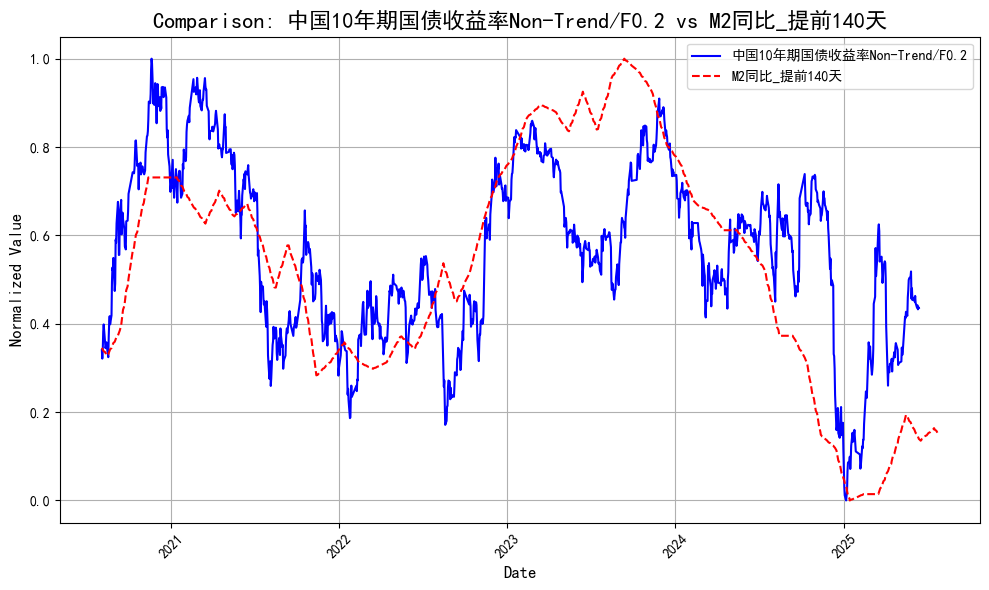

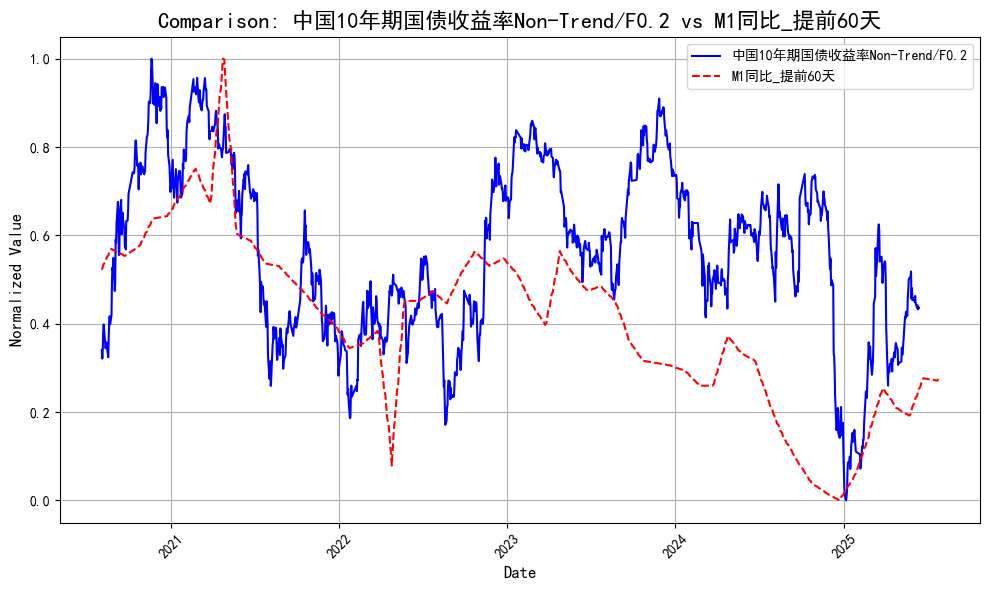

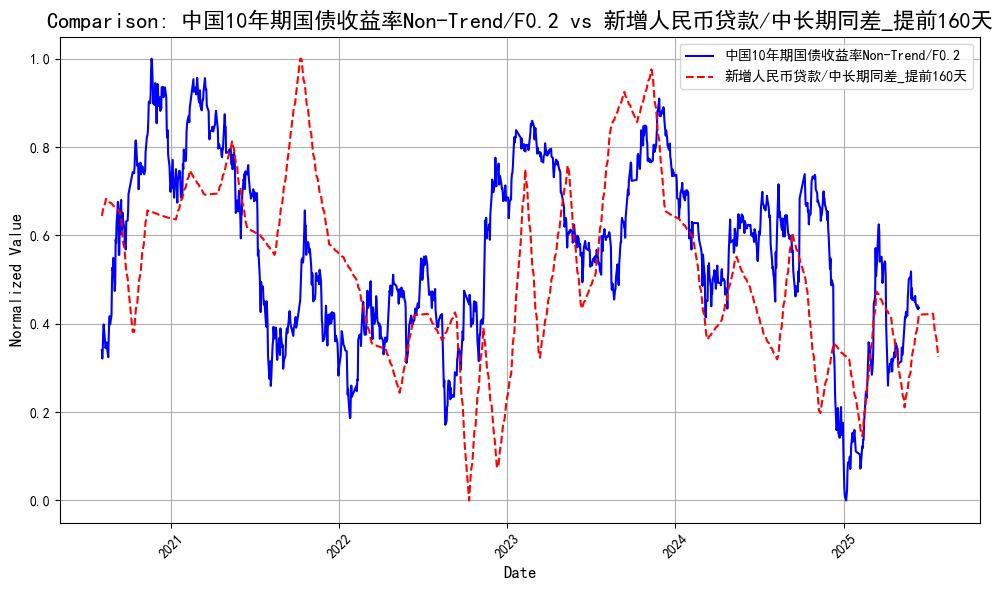

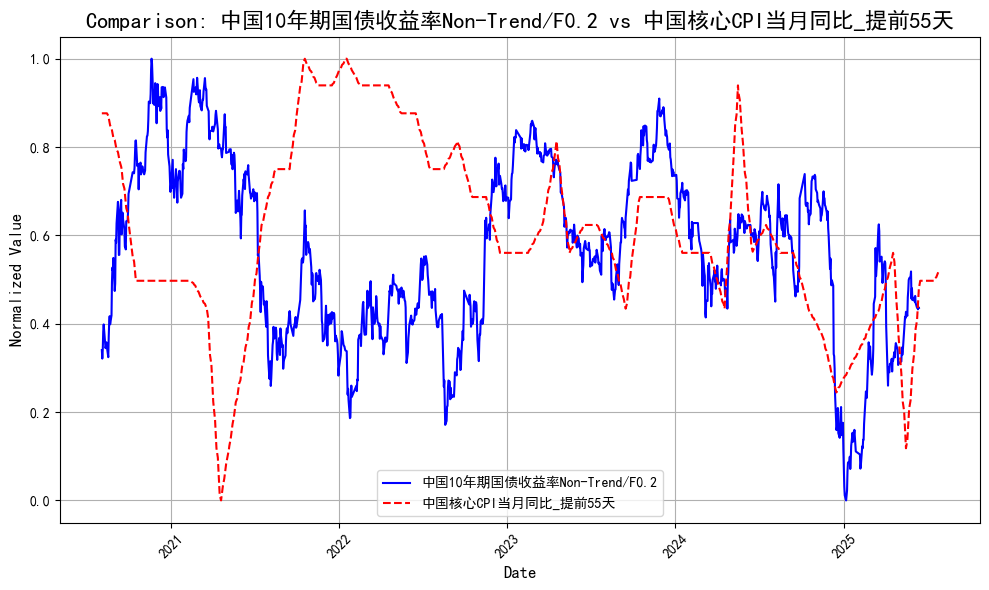

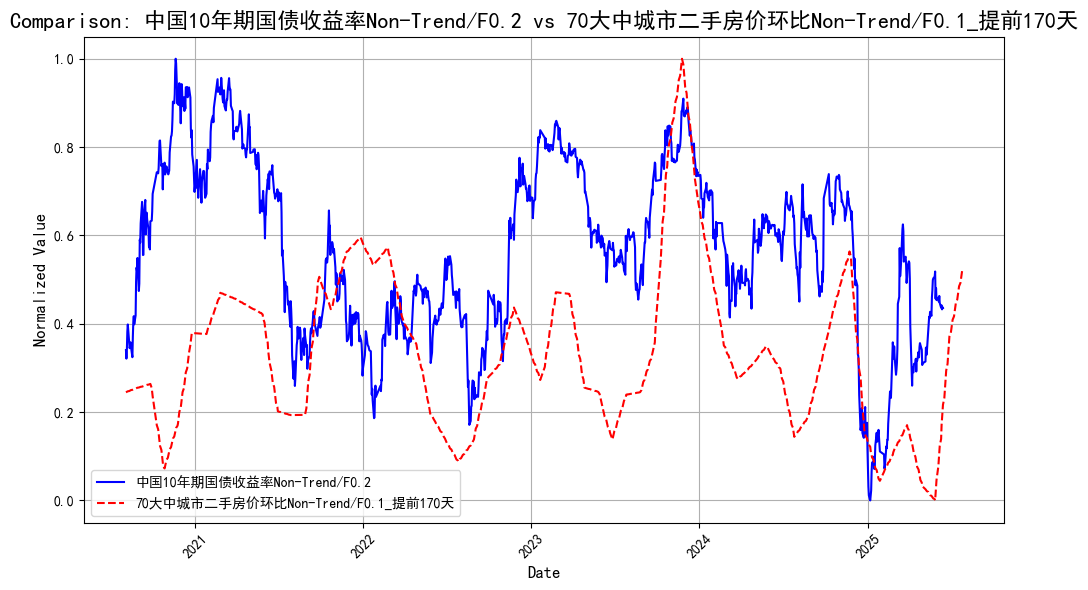

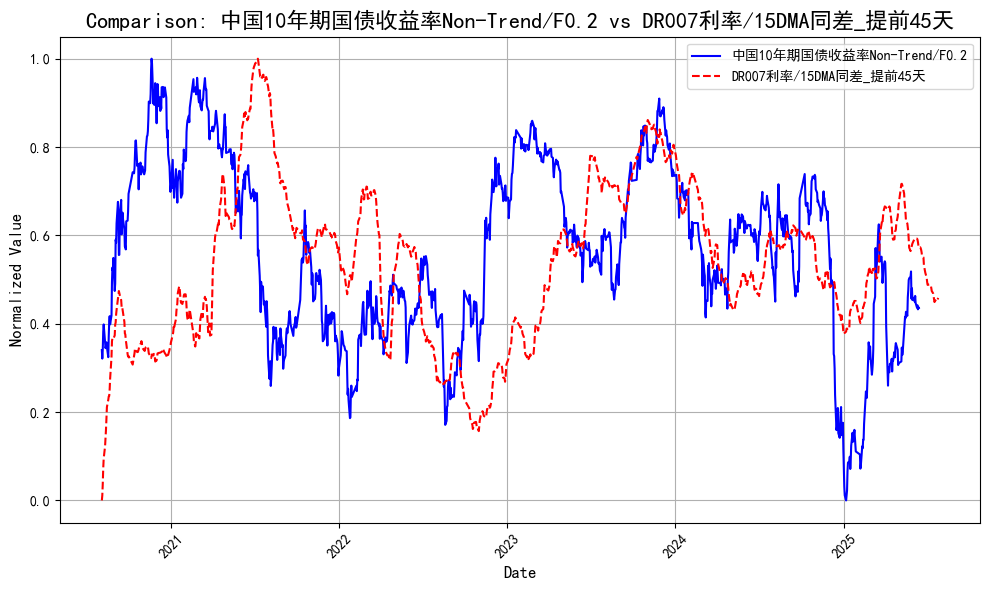

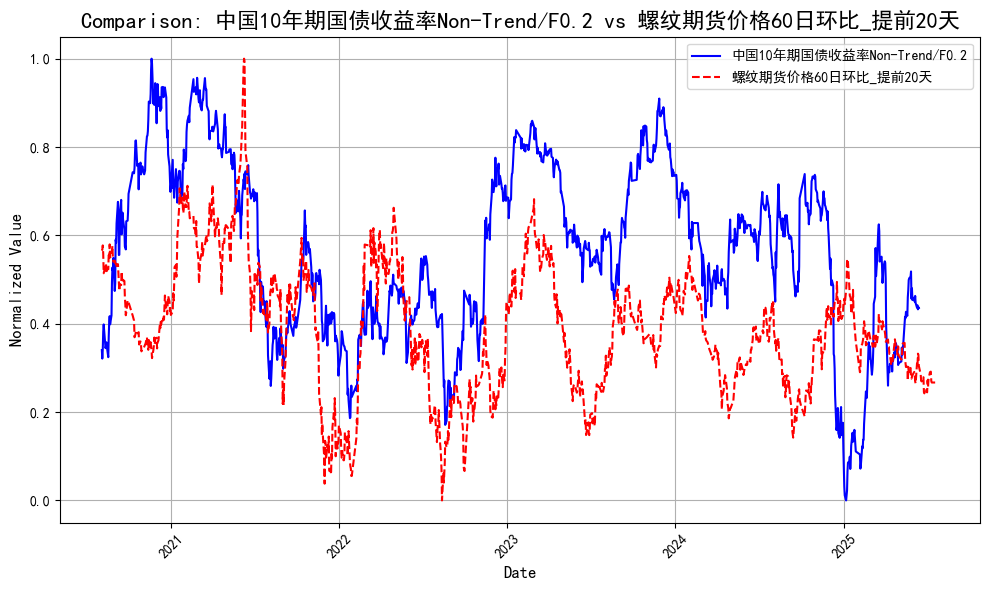

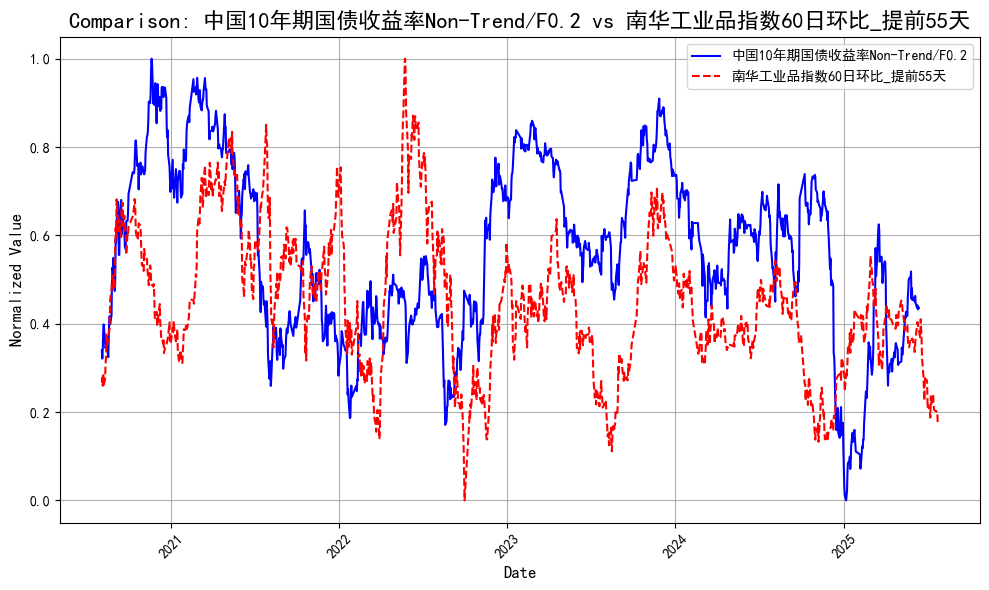

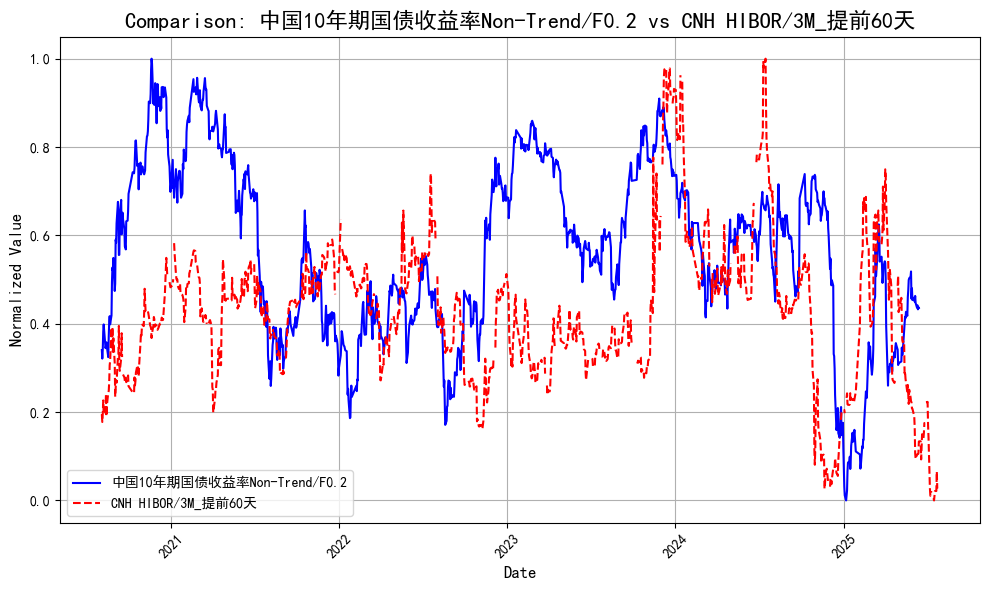

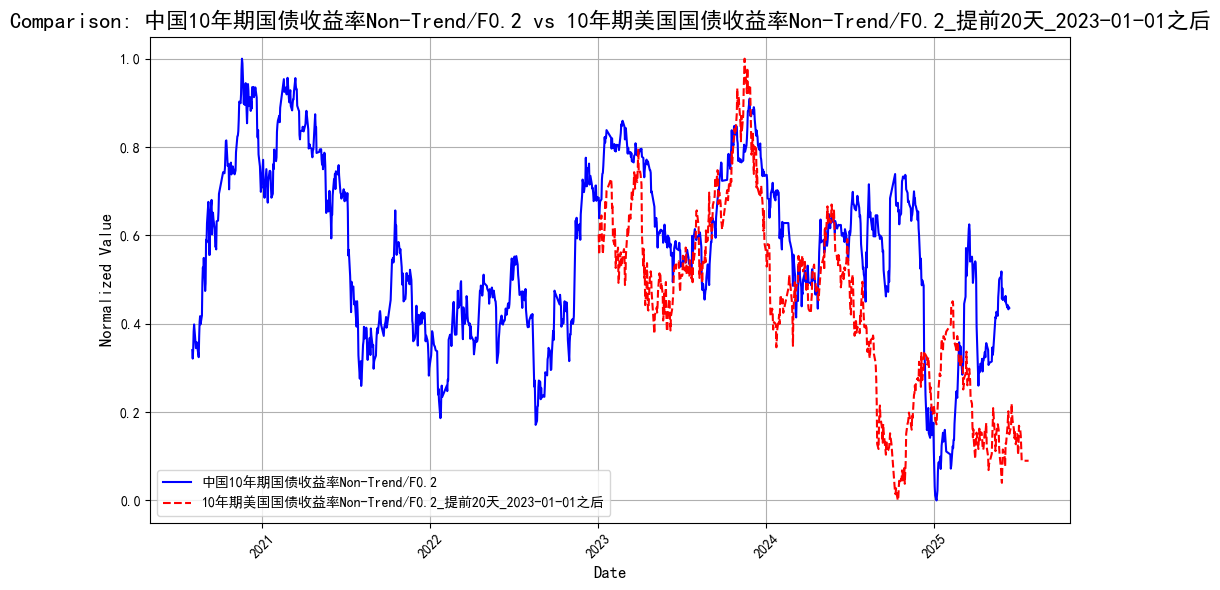

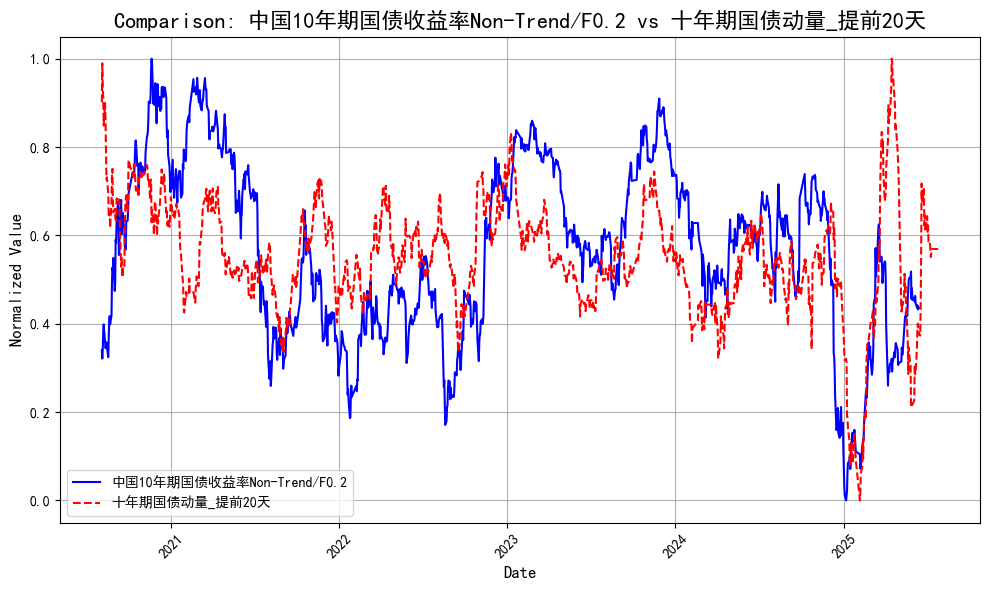

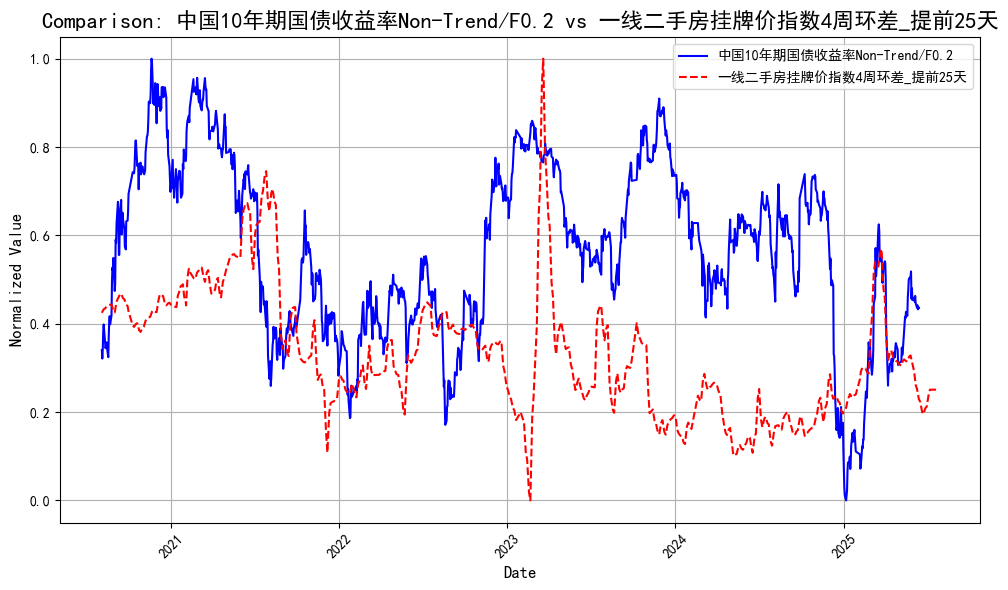

In [39]:
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国10年期国债收益率Non-Trend/F0.2', 
    compare_cols=[
        'M2同比_提前140天', 
        'M1同比_提前60天',
        '新增人民币贷款/中长期同差_提前160天', 
        '中国核心CPI当月同比_提前55天',
        '70大中城市二手房价环比Non-Trend/F0.1_提前170天', 
        'DR007利率/15DMA同差_提前45天',
       '螺纹期货价格60日环比_提前20天', 
       '南华工业品指数60日环比_提前55天', 
       'CNH HIBOR/3M_提前60天',
       '10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后',
       '十年期国债动量_提前20天',
       '一线二手房挂牌价指数4周环差_提前25天'
                  ]
)

In [40]:

# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 30
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]


In [41]:
feature_columns = [
        'M2同比_提前140天', 
        'M1同比_提前60天',
        '新增人民币贷款/中长期同差_提前160天', 
        '中国核心CPI当月同比_提前55天',
        '70大中城市二手房价环比Non-Trend/F0.1_提前170天', 
        'DR007利率/15DMA同差_提前45天',
        '螺纹期货价格60日环比_提前20天', 
        '南华工业品指数60日环比_提前55天', 
        'CNH HIBOR/3M_提前60天',
        '10年期美国国债收益率Non-Trend/F0.2_提前20天_2023-01-01之后',
        '十年期国债动量_提前20天',
        '一线二手房挂牌价指数4周环差_提前25天'
]


# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data['中国10年期国债收益率Non-Trend/F0.2']

X_test = test_data[feature_columns]
y_test = test_data['中国10年期国债收益率Non-Trend/F0.2']

X_future = future_data[feature_columns]

In [42]:
################################# TabPFN 模型 训练 测试 预测 #################################
# 初始化回归器
regressor = TabPFNRegressor(ignore_pretraining_limits=True)
regressor.fit(X_train, y_train)

# 在测试集和未来数据上预测
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")
print(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")

# 存储预测结果
y_future_pred = regressor.predict(X_future)
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

训练集 MSE (TabPFN): 0.0001, 训练集 R² (TabPFN): 0.9949
测试集 MSE (TabPFN): 0.0074, 测试集 R² (TabPFN): -4.313


C:\Users\wxqp\AppData\Local\Temp\ipykernel_17580\946419797.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data.loc[:, '预测值'] = y_future_pred


In [55]:
################################# TabPFN 模型 训练 测试 预测 所有数据 #################################
# 合并所有数据
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 初始化回归器
regressor_all = TabPFNRegressor(ignore_pretraining_limits=True)
regressor_all.fit(X_all, y_all)

# 预测所有数据和未来数据
y_all_pred = regressor_all.predict(X_all)
y_future_pred_all = regressor_all.predict(X_future)

# 评估模型
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

KeyboardInterrupt: 

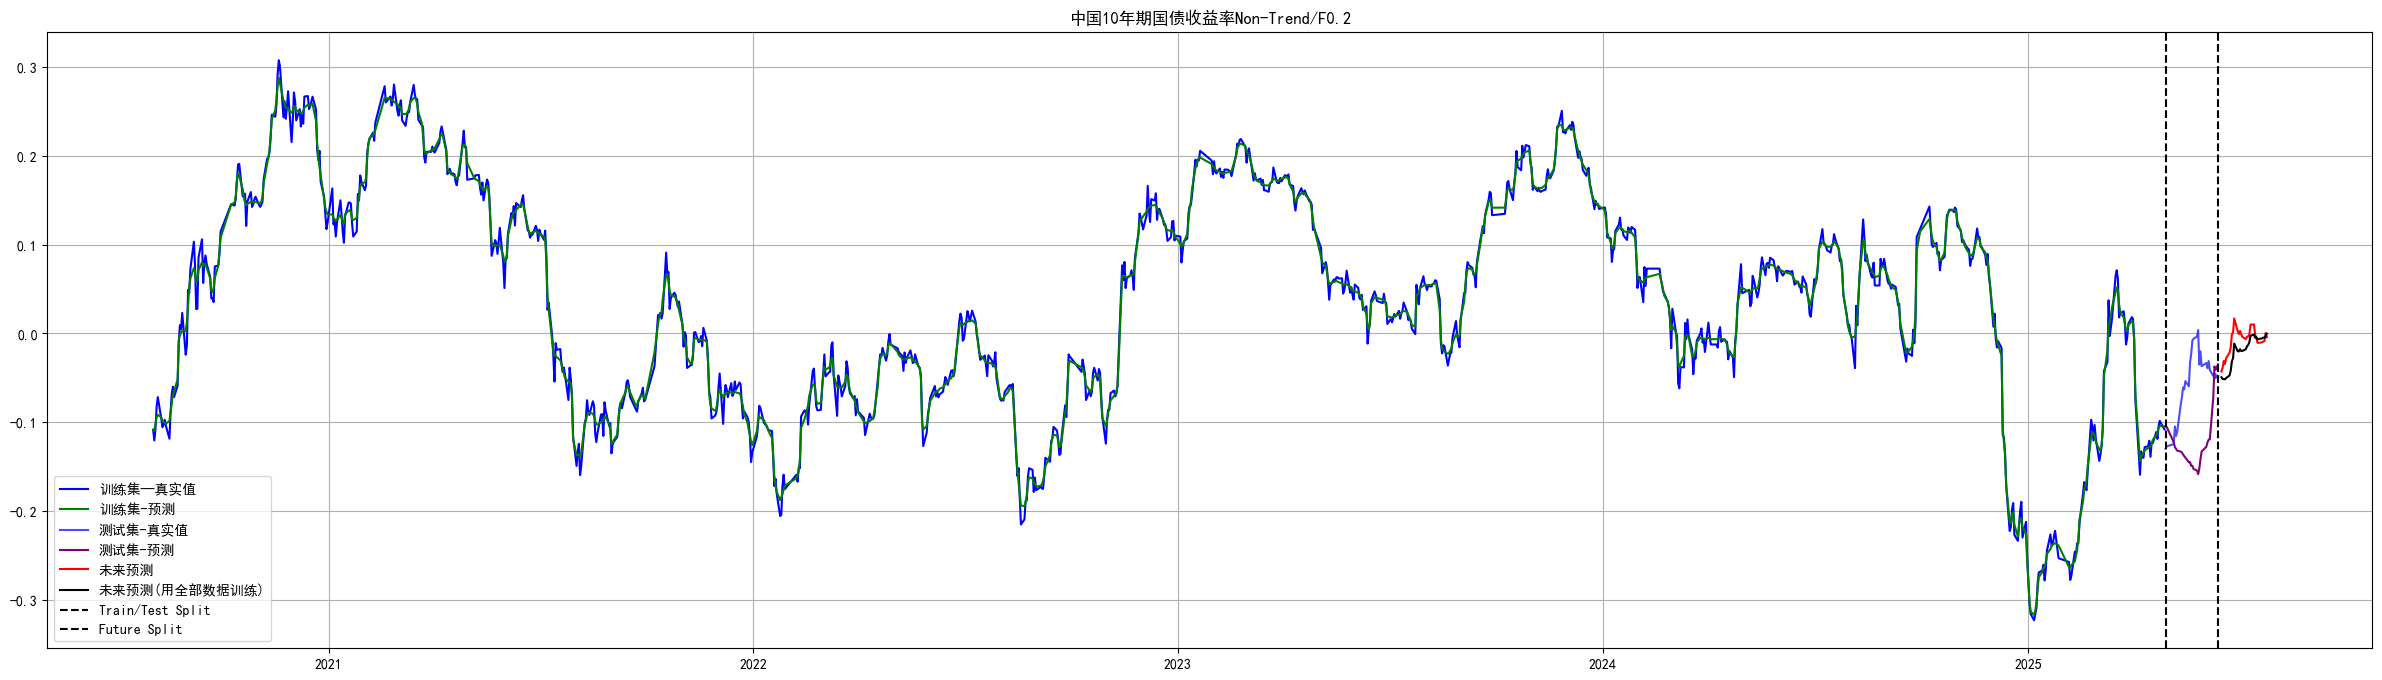

In [57]:

plt.figure(figsize=(30, 8))
#future_data = plot_predictions(y_test, future_data, col=True, label=True)

# 只显示2024年及以后的数据
mask_train = train_data['Date'].dt.year >= 2024
mask_test = test_data['Date'].dt.year >= 2024
mask_future = future_data['Date'].dt.year >= 2024

plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') 
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 在同一张图中添加真实数据线
#plt.plot(real_data['Date'], real_data['中国10年期国债收益率Non-Trend/F0.2'], label='未来30天真实值', color='orange', linestyle='--', linewidth=2)

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国10年期国债收益率Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()

---

In [58]:
'''
# 交换 '预测值_全量' 和 '预测值' 列名
future_data = future_data.rename(columns={
    '预测值_全量': '预测值_temp',  # 临时列名
    '预测值': '预测值_全量'
})

future_data = future_data.rename(columns={
    '预测值_temp': '预测值'  # 完成交换
})
'''
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '中国10年期国债收益率Non-Trend/F0.2']]
test_actual = test_data[['Date', '中国10年期国债收益率Non-Trend/F0.2']]
# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值_全量']]  # 修改这里的列名
# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')
merged_df = merged_df.sort_values('Date', ascending=False)
# 保存到Excel
merged_df.to_excel('eta/中国10年期国债收益率Non-Trend_合并数据.xlsx', index=False,float_format='%.5f')
merged_df

,Date,实际值,预测值_全量
619,2025/07/25,NaN,-0.000180
618,2025/07/24,NaN,-0.003150
617,2025/07/23,NaN,-0.004734
616,2025/07/22,NaN,-0.004620
615,2025/07/21,NaN,-0.005521
...,...,...,...
4,2023/01/09,0.1068,NaN
3,2023/01/06,0.1037,NaN
2,2023/01/05,0.0929,NaN
1,2023/01/04,0.0799,NaN


In [59]:
# 任务2: 生成月度数据
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
merged_df_monthly.to_excel('eta/中国10年期国债收益率Non-Trend_月度数据.xlsx', index=False,float_format='%.2f')
merged_df_monthly.head()                       


,Date,真实值,预测值
30,2025/07/31,NaN,-0.009270
29,2025/06/30,-0.042411,-0.057251
28,2025/05/31,-0.052937,-0.140602
27,2025/04/30,-0.109214,-0.106248
26,2025/03/31,-0.011476,-0.010855


---

In [60]:
future_predictions_nontrend = merged_df[['Date', '预测值_全量']]
future_predictions_nontrend = future_predictions_nontrend.dropna()
future_predictions_nontrend['Date'] = pd.to_datetime(future_predictions_nontrend['Date'])
future_predictions_nontrend = future_predictions_nontrend.sort_values('Date')
future_predictions_nontrend.to_csv('data_output/中国10年期国债收益率Non-Trend-F0.2_未来日度预测.csv', index=False)
future_predictions_nontrend.head()

,Date,预测值_全量
590,2025-06-16,-0.049298
591,2025-06-17,-0.051195
592,2025-06-18,-0.051334
593,2025-06-19,-0.051673
594,2025-06-20,-0.050170


---

In [61]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国10年期国债收益率Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [62]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国10年期国债收益率Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/06/30)
数据已成功更新到Excel文件


In [63]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df,
    target_name = '中国10年期国债收益率Non-Trend/F0.2',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值_全量',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
    '''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df,\n    target_name = \'中国10年期国债收益率Non-Trend/F0.2\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值_全量\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n    '